<a href="https://colab.research.google.com/github/weicuivt/Affine/blob/master/ML_HYM_CY3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ML HYM connection of a SU(3) bundle on CY3 surface 

This introduction demonstrates how to use MLGeometry to: 

1. Generate a hypersurface.
2. Build a bihomogeneous neural network and use that to compute numerical Calabi-Yau metrics. Test the performance with the testset. 
3. Define the bundle. 
4. Build a bihomogeneous neural network to learn the HYM connection.
5. Test the performance of ML approach on testset and compare with the Donaldson's algorithm. 


https://blog.csdn.net/qq_37389133/article/details/79293430

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/ML_HYM_CY3
!ls

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/ML_HYM_CY3
CHANGELOG.md  MLGeometry  ML_HYM_CY3.ipynb  numericalhym  training


## Configure imports

Import tensorflow_probability to use the L-BFGS optimizer:

In [2]:
import sympy as sp
import tensorflow as tf
import tensorflow.python.keras.backend as K
import tensorflow_probability as tfp

import MLGeometry as mlg
from MLGeometry import bihomoNN as bnn

import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)
tf.random.set_seed(42)

import numericalhym.complex_derivatives as cd

## Define a hypersurface
First define a set of coordinates and a function as sympy symbols:

Wei's comments: 

*  **Z**: homogeneous coordinates
*  **f**: defining polynomial of hypersurface in P^4
*   **n_pairs**: # of sample on each patch 
*   **HS_train**: a instance of hypersurface class 
*   **HS_test**:  a instance of hypersurface class




In [4]:
z0, z1, z2, z3, z4 = sp.symbols('z0, z1, z2, z3, z4')
Z = [z0,z1,z2,z3,z4]
f = z0**5 + z1**5 + z2**5 + z3**5 + z4**5 + 0.5*z0*z1*z2*z3*z4

n_pairs = 2000
HS_train = mlg.hypersurface.Hypersurface(Z, f, n_pairs)
HS_test = mlg.hypersurface.Hypersurface(Z, f, n_pairs)

HS_train.list_patches()
HS_train.patches[0].list_patches()

Number of Patches: 5
Points on patch 1 : 2020
Points on patch 2 : 1994
Points on patch 3 : 1952
Points on patch 4 : 2012
Points on patch 5 : 2022
Number of Patches: 4
Points on patch 1 : 529
Points on patch 2 : 483
Points on patch 3 : 505
Points on patch 4 : 503


## Convert to Tensorflow Dataset

*   **train_set**: Tensorflow Dataset for training 
*   **test_set**:  Tensorflow Dataset for testing 
*   **train_setM**:  minibatch dataset for metric training
*   **test_setM**:   minibatch dataset for metric testing

*   **points**:         points on the hypersurface  
*   **Omega_Omegabar**: $\small \Omega \wedge \bar\Omega$  
*   **mass**:           mass  
*   **restriction**:    restriction matrix 1 converting gradient of homogeneous coordinates to the coordinates on the hypersurface. 

In [6]:
train_set = mlg.tf_dataset.generate_dataset(HS_train)
test_set = mlg.tf_dataset.generate_dataset(HS_test)

train_set1 = train_set.shuffle(HS_train.n_points).batch(1000)
test_set1 = test_set.shuffle(HS_test.n_points).batch(1000)

points, Omega_Omegabar, mass, restriction = next(iter(train_set1))
print(points[0])
print(Omega_Omegabar[0])
print(mass[0])
print(restriction[0])

tf.Tensor(
[ 0.12615436+0.20734908j -0.92164963-0.16501299j  1.        +0.j
  0.21388292-0.13885647j  0.6643115 -0.6734965j ], shape=(5,), dtype=complex64)
tf.Tensor(0.061654072, shape=(), dtype=float32)
tf.Tensor(1.2584366, shape=(), dtype=float32)
tf.Tensor(
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j         -0.01340217+0.02222157j]
 [ 0.        +0.j          1.        +0.j          0.        +0.j
   0.        +0.j          0.71680045+0.63524795j]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   1.        +0.j         -0.02765523-0.01516288j]], shape=(3, 5), dtype=complex64)


### Build a bihomogeneous neural network 




In [7]:
from keras.layers import Dense

class Kahler_potential(tf.keras.Model):
    def __init__(self):
        super(Kahler_potential, self).__init__()
        # The first layer transforms the complex points to the bihomogeneous form.
        # The number of the outputs is d^2, where d is the number of coordinates.
        self.bihomogeneous = bnn.Bihomogeneous()
        self.layer1 = bnn.Dense(5**2, 70, activation=tf.square)
        self.layer2 = bnn.Dense(70, 100, activation=tf.square)
        self.layer3 = bnn.Dense(100, 1)
        # self.layer1 = Dense( 70, activation=tf.square)
        # self.layer2 = Dense( 100, activation=tf.square)
        # self.layer3 = Dense( 1)
    
    def call(self, inputs):
        x = self.bihomogeneous(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = tf.math.log(x)
        return x

model = Kahler_potential()

In [8]:
@tf.function
def volume_form(points, Omega_Omegabar, mass, restriction):
    
    kahler_metric = mlg.complex_math.complex_hessian(tf.math.real(model(points)), points)
    volume_form = tf.matmul(restriction, tf.matmul(kahler_metric, restriction, adjoint_b=True)) 
    volume_form = tf.math.real(tf.linalg.det(volume_form))
    
    # Calculate the normalization constant to make the overall integration as 1
    # It is a batchwise calculation but we expect it to converge to a constant eventually
    weights = mass / tf.reduce_sum(mass)
    factor = tf.reduce_sum(weights * volume_form / Omega_Omegabar)
    
    return volume_form / factor

@tf.function
def get_metric(points, restriction):
    
    kahler_metric = mlg.complex_math.complex_hessian(tf.math.real(model(points)), points)
    volume_form = tf.matmul(restriction, tf.matmul(kahler_metric, restriction, adjoint_b=True)) 
  
    return volume_form


def gradients_zbar(func, x):
    dx_real = tf.gradients(tf.math.real(func), x)
    dx_imag = tf.gradients(tf.math.imag(func), x)
    return (dx_real + dx_imag*tf.constant(1j, dtype=x.dtype)) / 2

@tf.autograph.experimental.do_not_convert
def complex_hessian(func, x):
    # Take a real function and calculate dzdzbar(f)
    #grad = gradients_z(func, x)
    grad = tf.math.conj(tf.gradients(func, x))
    hessian = tf.stack([gradients_zbar(tmp[0], x)[0]
                        for tmp in tf.unstack(grad, axis=2)],
                       axis = 1) / 2.0
 
    return hessian 


### Train the metric model with Adam 


epoch 5: loss = 0.75131
epoch 10: loss = 0.49746
epoch 15: loss = 0.36619
epoch 20: loss = 0.32214
epoch 25: loss = 0.27885
epoch 30: loss = 0.21667
epoch 35: loss = 0.15926
epoch 40: loss = 0.10493
epoch 45: loss = 0.06642
epoch 50: loss = 0.05976
epoch 55: loss = 0.05704
epoch 60: loss = 0.05220
epoch 65: loss = 0.05162
epoch 70: loss = 0.05099
epoch 75: loss = 0.05015
epoch 80: loss = 0.04942
epoch 85: loss = 0.04868
epoch 90: loss = 0.04710
epoch 95: loss = 0.04430
epoch 100: loss = 0.04342


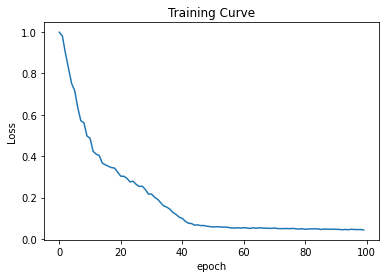

In [10]:
optimizer = tf.keras.optimizers.Adam()
loss_func = mlg.loss.weighted_MAPE


max_epochs = 100
epoch = 0

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.1,
            decay_steps = 100000,
            decay_rate = 0.5)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

losses = []
while epoch < max_epochs:
    epoch = epoch + 1
    for step, (points, Omega_Omegabar, mass, restriction) in enumerate(train_set1):
        with tf.GradientTape() as tape:
            det_omega = volume_form(points, Omega_Omegabar, mass, restriction)
            loss = loss_func(Omega_Omegabar, det_omega, mass)
            grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    if epoch % 5 == 0:
        print("epoch %d: loss = %.5f" % (epoch, loss))

    losses.append(loss)

# Learning curve
plt.plot(range(epoch), losses)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('Training Curve');

##Test the metric model 

In [11]:
def cal_total_loss(dataset, loss_function):
    total_loss = tf.constant(0, dtype=tf.float32)
    total_mass = tf.constant(0, dtype=tf.float32)
    
    for step, (points, Omega_Omegabar, mass, restriction) in enumerate(dataset):
        det_omega = volume_form(points, Omega_Omegabar, mass, restriction)
        mass_sum = tf.reduce_sum(mass)
        total_loss += loss_function(Omega_Omegabar, det_omega, mass) * mass_sum
        total_mass += mass_sum
    total_loss = total_loss / total_mass

    return total_loss.numpy()

sigma_test = cal_total_loss(test_set1, mlg.loss.weighted_MAPE)
sigma_test2 = cal_total_loss(train_set1, mlg.loss.weighted_MAPE)
print("sigma_test = %.5f" % sigma_test)
print("sigma_train = %.5f" % sigma_test2)


E_test = cal_total_loss(test_set1, mlg.loss.weighted_MSE)
E_test2 = cal_total_loss(train_set1, mlg.loss.weighted_MSE)
print("E_test = %.5f" % E_test)
print("E_train = %.5f" % E_test2)

# def delta_sigma_square_test(y_true, y_pred, mass):
#     weights = mass / K.sum(mass)
#     return K.sum((K.abs(y_true - y_pred) / y_true - sigma_test)**2 * weights)

# delta_sigma = cal_total_loss(test_set1, delta_sigma_square_test)
# print("delta_simga = %.5f" % delta_sigma)

sigma_test = 0.04617
sigma_train = 0.04415
E_test = 0.00364
E_train = 0.00337


# Definition of the bundle



In [12]:
z0, z1, z2, z3, z4 = sp.symbols('z0, z1, z2, z3, z4')
Z = [z0,z1,z2,z3,z4]
f = z0**5 + z1**5 + z2**5 + z3**5 + z4**5 + 0.5*z0*z1*z2*z3*z4

Bterm = [1,1,1,1]
Cterm = [4]
rank = len(Bterm) - len(Cterm)

# bundle maps 
Fmaps = [z0**3, z1**3, z2**3, z3**3]
Fmaps_eval = sp.lambdify(Z, Fmaps, 'numpy')

# gradient of bundle maps 
grads1 = sp.zeros(len(Z),rank)
for i, s in enumerate(Z): 
  for j in range(rank):
    grads1[i,j] = sp.diff(Fmaps[j]/Fmaps[0], s)

grads2 = sp.zeros(len(Z),rank)
for i, s in enumerate(Z): 
  for j in range(rank):
    grads2[i,j] = sp.diff(Fmaps[j]/Fmaps[1], s)

grads3 = sp.zeros(len(Z),rank)
for i, s in enumerate(Z): 
  for j in range(rank):
    grads3[i,j] = sp.diff(Fmaps[j]/Fmaps[2], s)

grads4 = sp.zeros(len(Z),rank)
for i, s in enumerate(Z): 
  for j in range(rank):
    grads3[i,j] = sp.diff(Fmaps[j]/Fmaps[3], s)

grads1_eval = sp.lambdify(Z, grads1, 'numpy')
grads2_eval = sp.lambdify(Z, grads2, 'numpy')
grads3_eval = sp.lambdify(Z, grads3, 'numpy')
grads4_eval = sp.lambdify(Z, grads4, 'numpy')

gradsFmaps_eval = [grads1_eval, grads2_eval, grads3_eval,grads4_eval]
# print(type(gradsFmaps_eval[0]))


# Add the addition data to Tensorflow dataset

*   CY metric
*   R2 matrix
*   R3 matrix

*   **datasetB**: Tensorflow Dataset for training bundle 
*   **train_setB**:  Tensorflow Dataset for training bundle in batch



In [13]:
def getBundleSet(train_set):
  train_set_list = list(train_set.as_numpy_iterator())
  train_set_list2 = list(zip(*train_set_list))
  
  points = np.asarray(train_set_list2[0]) 
  Omega_Omegabar = np.asarray(train_set_list2[1]) 
  mass = np.asarray(train_set_list2[2]) 
  restriction = np.asarray(train_set_list2[3]) 
  cymetric = get_metric(points, restriction)
  cymetric = np.asarray(cymetric) 
  # print(cymetric[0])
  # print(len(cymetric))


  maxframes = []
  R2s = []
  R3s = []

  for pt in points:
    # find the max frame 
    fmaps = Fmaps_eval(*pt)
    fmaps_norm = np.absolute(fmaps).tolist()
    max_frame_index = fmaps_norm.index(max(fmaps_norm))
    maxframes. append(max_frame_index)

    # get the R2 matrix 
    tr2 = (fmaps/fmaps[max_frame_index]).tolist()
    r2 = np.delete(tr2,[max_frame_index])*(-1)
    tR2 = np.array([[1+0j,0+0j,0+0j],[0+0j,1+0j,0+0j],[0+0j,0+0j,1+0j]])
    R2 = np.insert(tR2, max_frame_index, r2, axis = 1)
    R2s.append(R2)

    # get the R3 matrix 
    tt = gradsFmaps_eval[max_frame_index](*pt)
    tR3 = np.array([[0+0j,0+0j,0+0j],[0+0j,0+0j,0+0j],[0+0j,0+0j,0+0j]])
    R3 = []
    for i in range(len(Z)):
      r3 = np.insert(tR3, max_frame_index, tt[i], axis = 1).tolist()
      R3.append(r3)
    R3s.append(R3)

  # print(len(maxframes))
  # print(len(R2s))
  # print(R2s[1])
  # print(len(R3s))
  # print(R3s[1])


  R2s = np.array(R2s).astype(np.complex64)
  R3s = np.array(R3s).astype(np.complex64)
  # print(type(R2s))
  return tf.data.Dataset.from_tensor_slices((points, Omega_Omegabar, mass, restriction, cymetric, R2s, R3s))

In [14]:
# train set for bundle
datasetBtrain = getBundleSet(train_set)
datasetBtrain_batch = datasetBtrain.shuffle(HS_train.n_points).batch(1000)
# test set for bundle
datasetBtest = getBundleSet(test_set)
datasetBtest_batch = datasetBtest.shuffle(HS_test.n_points).batch(1000)

# NN for $S_B$

## Setup the one-layer NN to test the lose function!!!


In [89]:
class SectionCY3B3(tf.keras.Model):
    def __init__(self):
        super(SectionCY3B3, self).__init__()
        # The first layer transforms the complex points to the bihomogeneous form.
        # The number of the outputs is d^2, where d is the number of coordinates.
        self.bihomogeneous = bnn.Bihomogeneous()
        self.layer1 = bnn.Dense(5**2, 100, activation=tf.square)
        # self.layer2 = bnn.Dense(20, 30, activation=tf.square)
        # self.layer3 = bnn.Dense(30, 50, activation=tf.square)
        # self.layer4 = bnn.Dense(70, 80, activation=tf.square)
        self.layer5 = bnn.Dense(100, 24)
        
    
    def call(self, inputs):
        x = self.bihomogeneous(inputs)
        x = self.layer1(x)
        # x = self.layer2(x)
        # x = self.layer3(x)
        # x = self.layer4(x)
        x = self.layer5(x)
        return x

modelB3 = SectionCY3B3()

In [90]:
modelB3(tpoints)

<tf.Tensor: shape=(1000, 24), dtype=float32, numpy=
array([[ 0.000934  ,  0.02531736,  0.15816261, ...,  0.11066248,
        -0.09922633,  0.04656654],
       [ 0.01132716, -0.02412906, -0.00195423, ...,  0.13350531,
         0.03762478, -0.00941934],
       [ 0.01100525,  0.15368535, -0.01219278, ...,  0.08476941,
         0.06784526, -0.00657476],
       ...,
       [-0.26150307,  0.00304703,  0.01505594, ...,  0.18974409,
        -0.17940539,  0.10390006],
       [-0.06640899,  0.08208568, -0.04715982, ...,  0.07944436,
         0.0460159 ,  0.08783581],
       [ 0.10133582,  0.0314403 ,  0.10377097, ...,  0.11824094,
        -0.12165272,  0.03133258]], dtype=float32)>

In [86]:
tpoints[0:2]

<tf.Tensor: shape=(2, 5), dtype=complex64, numpy=
array([[ 0.8541581 +5.1853675e-01j,  0.7038202 -2.5583676e-01j,
         1.        +5.2028248e-17j,  0.41965923+6.3354260e-01j,
         0.0552639 +4.5191187e-01j],
       [ 1.        +0.0000000e+00j,  0.5081815 +1.8659671e-01j,
        -0.04914504-3.7141296e-01j, -0.07774837+5.8677137e-01j,
        -0.29802477-9.4293857e-01j]], dtype=complex64)>

# General H matrix in the ansatz:

In [81]:
ttH=[[0.8, 0.3+0.65j, 0.8 - 0.23j], [0.3-0.65j, 0.32, 0.52 +
 0.11j], [0.8 + 0.23j, 0.52 - 0.11j, 0.29 ]]
ttH1= [[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]]
tH = np.array(ttH1).astype(np.complex64)
H = tf.convert_to_tensor(tH)

# Loss function (in progress)

  # Notation:
    # p: index of points in a batch
    # I: holomorphic gauge index of B
    # J: anti-holomorphic gauge index of B
    # i: holomorphic gauge index of V
    # j: anti-holomorphic gauge index of V
    # A: holomorphic gradient of spacetime on P^3
    # B: anti-holomorphic gradient of spacetime on P^3
    # a: holomorphic gradient of spacetime on X
    # b: anti-holomorphic gradient of spacetime on X



In [91]:
@tf.function
def lossB3(tpoints, Omega_Omegabar, mass, restriction, cymetric, R2s, R3s):
    
    with tf.GradientTape(persistent=True) as g: 
        g.watch(tpoints)
        Sbs = modelB3(tpoints)
        tSbs = tf.complex(Sbs[:,0:12], Sbs[:,12:24])
    # Here you can have the other code for Svs1, tSvs1, inG, etc.
    # Since you’re not taking derivatives of them, you can put them either
    # inside or outside the with statement
    # However, if you are going to take derivatives of them, make sure
    # they are calculated within a with block (or after ensuring the tape is recording)

    dSb = cd.batch_jacobian_dz(g, tSbs, tpoints)

    invCYmetric = tf.linalg.inv(cymetric)
    

    SbsM = tf.stack([tSbs[:,0:4],tSbs[:,4:8],tSbs[:,8:12]], 1)
    SvsM = tf.einsum('piI,pMI->pMi', R2s,SbsM)
    inG = tf.einsum('pjM,pMi->pji',
        tf.einsum('pNj,NM->pjM',tf.math.conj(SvsM),H),SvsM)
    G = tf.linalg.inv(inG)


    dSbM = tf.stack([dSb[:,0:4],dSb[:,4:8],dSb[:,8:12]], 1)
    tdSvM = tf.einsum('piI,pMIA->pMiA',R2s,dSbM)
    dSvM = tf.add(tdSvM, tf.einsum('pAiI,pMI->pMiA',R3s, SbsM))
    DSvM = tf.einsum('paA,pMiA->pMia', restriction, dSvM)

    
    # 1st term  
    tddinG = tf.einsum('pjbM, pMia -> pjiba',
        tf.einsum('pNjb,NM->pjbM',tf.math.conj(DSvM),H),DSvM)
    
    ddinG = tf.einsum('pba,pjiba->pji', invCYmetric, tddinG)

    # 2nd term
    dinG1 = tf.einsum('pjM, pMia -> pjia',
        tf.einsum('pNj,NM->pjM',tf.math.conj(SvsM), H),DSvM)
    
    dinG2 = tf.einsum('pjMb, pMi -> pjib',
        tf.einsum('pNjb,NM->pjMb',tf.math.conj(DSvM), H),SvsM)
    
    tddGGG = tf.einsum('pjka,pkib->pjiab', 
                       tf.einsum('pjia,pik->pjka',dinG1, G), dinG2)
    
    ddGGG = tf.einsum('pba,pjiab->pji',invCYmetric, tddGGG)

    twM = tf.einsum('pji,pik->pjk', tf.math.subtract(ddGGG,ddinG), G)

    # 1st loss function 
    tL1 = tf.math.pow(tf.abs(tf.math.subtract(twM[:,0,0], twM[:,1,1])),2)/2.0 + tf.math.add(tf.math.pow(tf.abs(twM[:,0,1]),2) , tf.math.pow(tf.abs(twM[:,1,0]),2))
    # volX = tf.reduce_sum(mass).numpy()
    # weights = mass / tf.math.reduce_sum(mass)
    weights = mass / tf.reduce_sum(mass)
    L1 = tf.einsum('p,p->',tL1,weights)

    # 2nd loss function
    # L2 = tf.math.reduce_sum(tf.math.divide(1.0, tf.math.pow(tf.math.abs(SvsM),2)))
    
    # w1=1.0
    # w2=0.0
    # L = tf.math.add(w1*L1,w2*L2)
    
    return L1



# Train the bundle model 



---



In [95]:
optimizer = tf.keras.optimizers.Adam()
# loss_func = mlg.loss.weighted_MAPE

max_epochs = 1
epoch = 0

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.1,
            decay_steps = 100000,
            decay_rate = 0.5
            )
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)



while epoch < max_epochs:
    epoch = epoch + 1
    for step, (tpoints, Omega_Omegabar, mass, restriction, cymetric, R2s, R3s) in enumerate(datasetBtrain_batch):
        print(step)
        with tf.GradientTape() as tape:
            loss = lossB3(tpoints, Omega_Omegabar, mass, restriction, cymetric, R2s, R3s)
            grads = tape.gradient(loss, modelB3.trainable_weights)
           
        optimizer.apply_gradients(zip(grads, modelB3.trainable_weights))
    # if epoch % 1 == 0:
    #     print("epoch %d: loss = %.5f" % (epoch, loss))


InvalidArgumentError: ignored

In [84]:
ttt = modelB3(tpoints)
ttt[1:3]

<tf.Tensor: shape=(2, 24), dtype=float32, numpy=
array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
      dtype=float32)>

In [25]:
with tf.GradientTape(persistent=True) as g: 
        g.watch(tpoints)
        Sbs = modelB3(tpoints)
        tSbs = tf.complex(Sbs[:,0:12], Sbs[:,12:24])
        dSb = cd.batch_jacobian_dz(g, tSbs, tpoints)
    
    
invCYmetric = tf.linalg.inv(cymetric)
    

SbsM = tf.stack([tSbs[:,0:4],tSbs[:,4:8],tSbs[:,8:12]], 1)
SvsM = tf.einsum('piI,pMI->pMi', R2s,SbsM)
inG = tf.einsum('pjM,pMi->pji',
        tf.einsum('pNj,NM->pjM',tf.math.conj(SvsM),H),SvsM)
G = tf.linalg.inv(inG)


dSbM = tf.stack([dSb[:,0:4],dSb[:,4:8],dSb[:,8:12]], 1)
tdSvM = tf.einsum('piI,pMIA->pMiA',R2s,dSbM)
dSvM = tf.add(tdSvM, tf.einsum('pAiI,pMI->pMiA',R3s, SbsM))
DSvM = tf.einsum('paA,pMiA->pMia', restriction, dSvM)

    
# 1st term  
tddinG = tf.einsum('pjbM, pMia -> pjiba', tf.einsum('pNjb,NM->pjbM',tf.math.conj(DSvM),H),DSvM)
    
ddinG = tf.einsum('pba,pjiba->pji', invCYmetric, tddinG)

# 2nd term
dinG1 = tf.einsum('pjM, pMia -> pjia',tf.einsum('pNj,NM->pjM',tf.math.conj(SvsM), H),DSvM)
    
dinG2 = tf.einsum('pjMb, pMi -> pjib',tf.einsum('pNjb,NM->pjMb',tf.math.conj(DSvM), H),SvsM)
    
tddGGG = tf.einsum('pjka,pkib->pjiab', 
                       tf.einsum('pjia,pik->pjka',dinG1, G), dinG2)
    
ddGGG = tf.einsum('pba,pjiab->pji',invCYmetric, tddGGG)

twM = tf.einsum('pji,pik->pjk', tf.math.subtract(ddGGG,ddinG), G)

    

        

tL1 = tf.math.pow(tf.abs(tf.math.subtract(twM[:,0,0], twM[:,1,1])),2)/2.0 + tf.math.add(tf.math.pow(tf.abs(twM[:,0,1]),2) , tf.math.pow(tf.abs(twM[:,1,0]),2))
    
weights = mass / tf.reduce_sum(mass)
L1 = tf.einsum('p,p->',tL1,weights)


L

InvalidArgumentError: ignored

In [30]:
modelB3 = SectionCY3B3()
tpoints[0:2]

<tf.Tensor: shape=(2, 5), dtype=complex64, numpy=
array([[ 0.80755895-0.58261585j, -0.4637045 +0.13295728j,
         1.        -0.j        , -0.27136084-0.20586745j,
        -0.26203746-0.19624402j],
       [-0.31140676+0.90590733j,  0.0254997 -0.18712038j,
        -0.2967851 -0.6958547j ,  0.48480016-0.01826854j,
         1.        +0.j        ]], dtype=complex64)>

In [74]:
 Sbs = modelB3(tpoints)
 Sbs[0:2]

<tf.Tensor: shape=(2, 24), dtype=float32, numpy=
array([[ 0.05335655,  0.0304739 ,  0.12512514, -0.05349746, -0.05094995,
        -0.03738218, -0.0562264 ,  0.03788488,  0.01043772, -0.04013002,
        -0.10015127,  0.02587775, -0.07982294, -0.05224958,  0.04158115,
        -0.00054767,  0.06031071,  0.06170193,  0.0357704 , -0.01053821,
        -0.09719668, -0.06419479,  0.01127916,  0.07326891],
       [ 0.05950587, -0.0752193 , -0.11848453, -0.01341702, -0.01165547,
        -0.13672815,  0.02360401, -0.03816806,  0.11709575,  0.03189908,
        -0.08864836, -0.01345418, -0.00606438,  0.08152582,  0.05334831,
        -0.09800752,  0.07943001,  0.13751385, -0.03535741, -0.05347095,
         0.07477321, -0.13354476,  0.0137938 ,  0.14491966]],
      dtype=float32)>

In [72]:
with tf.GradientTape(persistent=True) as g: 
        g.watch(tpoints)
        Sbs = modelB3(tpoints)
        tSbs = tf.complex(Sbs[:,0:12], Sbs[:,12:24])
        dSb = cd.batch_jacobian_dz(g, tSbs, tpoints)
    
    
invCYmetric = tf.linalg.inv(cymetric)
    

SbsM = tf.stack([tSbs[:,0:4],tSbs[:,4:8],tSbs[:,8:12]], 1)
SvsM = tf.einsum('piI,pMI->pMi', R2s,SbsM)
inG = tf.einsum('pjM,pMi->pji',
        tf.einsum('pNj,NM->pjM',tf.math.conj(SvsM),H),SvsM)
G = tf.linalg.inv(inG)

dSbM = tf.stack([dSb[:,0:4],dSb[:,4:8],dSb[:,8:12]], 1)
tdSvM = tf.einsum('piI,pMIA->pMiA',R2s,dSbM)
dSvM = tf.add(tdSvM, tf.einsum('pAiI,pMI->pMiA',R3s, SbsM))
DSvM = tf.einsum('paA,pMiA->pMia', restriction, dSvM)

# 1st term  
tddinG = tf.einsum('pjbM, pMia -> pjiba', tf.einsum('pNjb,NM->pjbM',tf.math.conj(DSvM),H),DSvM)
    
ddinG = tf.einsum('pba,pjiba->pji', invCYmetric, tddinG)

# 2nd term
dinG1 = tf.einsum('pjM, pMia -> pjia',tf.einsum('pNj,NM->pjM',tf.math.conj(SvsM), H),DSvM)
    
dinG2 = tf.einsum('pjMb, pMi -> pjib',tf.einsum('pNjb,NM->pjMb',tf.math.conj(DSvM), H),SvsM)
    
tddGGG = tf.einsum('pjka,pkib->pjiab', 
                       tf.einsum('pjia,pik->pjka',dinG1, G), dinG2)
    
ddGGG = tf.einsum('pba,pjiab->pji',invCYmetric, tddGGG)

twM = tf.einsum('pji,pik->pjk', tf.math.subtract(ddGGG,ddinG), G)

# substract the trace
traceM = tf.linalg.trace(twM)
idenM = tf.cast(tf.eye(rank),tf.complex64)

ttraceMs = []
for trM in traceM:
  ttraceMs.append(tf.math.scalar_mul(trM,idenM))
traceMM = tf.stack(ttraceMs)

Mm = tf.math.subtract(twM,traceMM)
# Frobenius norm of a matrix 
tL1 = tf.cast(tf.norm(Mm, ord='fro', axis=[1,2]),tf.float32)

weights = mass / tf.reduce_sum(mass)
L1 = tf.einsum('p,p->',tL1,weights)


### zero-trace for rank-3 bundle:

In [ ]:
class SectionCY3B3(tf.keras.Model):
    def __init__(self):
        super(SectionCY3B3, self).__init__()
        # The first layer transforms the complex points to the bihomogeneous form.
        # The number of the outputs is d^2, where d is the number of coordinates.
        self.bihomogeneous = bnn.Bihomogeneous()
        self.layer1 = bnn.Dense(5**2, 100, activation=tf.square)
        # self.layer2 = bnn.Dense(20, 30, activation=tf.square)
        # self.layer3 = bnn.Dense(30, 50, activation=tf.square)
        # self.layer4 = bnn.Dense(70, 80, activation=tf.square)
        self.layer5 = bnn.Dense(100, 24)
        
    
    def call(self, inputs):
        x = self.bihomogeneous(inputs)
        x = self.layer1(x)
        # x = self.layer2(x)
        # x = self.layer3(x)
        # x = self.layer4(x)
        x = self.layer5(x)
        return x

modelB3 = SectionCY3B3()

In [77]:
with tf.GradientTape(persistent=True) as g: 
        g.watch(tpoints)
        Sbs = modelB3(tpoints)
        tSbs = tf.complex(Sbs[:,0:12], Sbs[:,12:24])
        dSb = cd.batch_jacobian_dz(g, tSbs, tpoints)
    
    
invCYmetric = tf.linalg.inv(cymetric)
    

SbsM = tf.stack([tSbs[:,0:4],tSbs[:,4:8],tSbs[:,8:12]], 1)
SvsM = tf.einsum('piI,pMI->pMi', R2s,SbsM)
inG = tf.einsum('pjM,pMi->pji',
        tf.einsum('pNj,NM->pjM',tf.math.conj(SvsM),H),SvsM)
G = tf.linalg.inv(inG)

dSbM = tf.stack([dSb[:,0:4],dSb[:,4:8],dSb[:,8:12]], 1)
tdSvM = tf.einsum('piI,pMIA->pMiA',R2s,dSbM)
dSvM = tf.add(tdSvM, tf.einsum('pAiI,pMI->pMiA',R3s, SbsM))
DSvM = tf.einsum('paA,pMiA->pMia', restriction, dSvM)

# 1st term  
tddinG = tf.einsum('pjbM, pMia -> pjiba', tf.einsum('pNjb,NM->pjbM',tf.math.conj(DSvM),H),DSvM)
    
ddinG = tf.einsum('pba,pjiba->pji', invCYmetric, tddinG)

# 2nd term
dinG1 = tf.einsum('pjM, pMia -> pjia',tf.einsum('pNj,NM->pjM',tf.math.conj(SvsM), H),DSvM)
    
dinG2 = tf.einsum('pjMb, pMi -> pjib',tf.einsum('pNjb,NM->pjMb',tf.math.conj(DSvM), H),SvsM)
    
tddGGG = tf.einsum('pjka,pkib->pjiab', 
                       tf.einsum('pjia,pik->pjka',dinG1, G), dinG2)
    
ddGGG = tf.einsum('pba,pjiab->pji',invCYmetric, tddGGG)

twM = tf.einsum('pji,pik->pjk', tf.math.subtract(ddGGG,ddinG), G)
tf.linalg.trace(twM)

<tf.Tensor: shape=(1000,), dtype=complex64, numpy=
array([ 2.00000000e+00-9.53125000e-01j, -2.38418579e-07+2.98023224e-08j,
        1.52587891e-05+1.52587891e-05j,  7.42187500e-02+1.31835938e-02j,
        0.00000000e+00+9.53674316e-07j,  1.78813934e-06+3.57627869e-07j,
        8.34465027e-07+8.94069672e-08j,  1.14440918e-05+1.90734863e-06j,
       -9.53674316e-06+5.72204590e-06j,  2.00000000e+00+1.25000000e-01j,
       -8.78906250e-03+2.25830078e-03j, -4.57763672e-05-4.91142273e-05j,
       -1.43051147e-06+7.15255737e-07j,  9.91821289e-05-2.28881836e-05j,
       -6.29145600e+06-1.25829120e+07j,  1.22070312e-04-1.22070312e-04j,
        0.00000000e+00+4.76837158e-07j,  6.10351562e-05+4.57763672e-05j,
       -7.62939453e-06+3.81469727e-06j,  7.62939453e-05+1.76429749e-05j,
        2.38418579e-06+2.14576721e-06j,  0.00000000e+00+6.10351562e-05j,
       -1.19209290e-05-2.62260437e-06j,  5.72204590e-06-4.76837158e-07j,
        4.68750000e-02+1.52343750e-01j,  1.90734863e-06-2.86102295e-06j,


In [78]:
pt=38

tttp1 = tf.einsum('ji,ik->jk', ddGGG[pt], G[pt])
tttp2 = tf.einsum('ji,ik->jk', ddinG[pt], G[pt])

print(tttp1)
print(tttp2)
print(tf.linalg.trace(tttp1))
print(tf.linalg.trace(tttp2))
print(tttp1-tttp2)
print(tf.linalg.eigvals(tttp1-tttp2))

tf.Tensor(
[[ 4.7510767 +1.4103642j   3.030204  -3.0342994j  -0.91628265-1.228914j  ]
 [ 0.3262481 +1.728576j    3.0218983 +0.6300832j  -0.07408494-0.18507016j]
 [ 1.228764  +5.9632454j   6.1071544 +1.0018202j   2.290801  -2.0404458j ]], shape=(3, 3), dtype=complex64)
tf.Tensor(
[[ 4.30995   +0.58058107j  2.8924015 -2.7123117j  -1.9547842 +0.37980443j]
 [ 1.0052717 +0.51186275j  1.7710493 -0.59444815j -0.30938724-0.05816805j]
 [-5.919473  -1.502262j   -4.4048996 +3.888932j    3.9827845 +0.01386831j]], shape=(3, 3), dtype=complex64)
tf.Tensor((10.063776+1.4305115e-06j), shape=(), dtype=complex64)
tf.Tensor((10.063784+1.2284145e-06j), shape=(), dtype=complex64)
tf.Tensor(
[[ 0.44112682+0.8297831j   0.1378026 -0.32198763j  1.0385015 -1.6087184j ]
 [-0.67902356+1.2167132j   1.250849  +1.2245314j   0.2353023 -0.1269021j ]
 [ 7.148237  +7.4655075j  10.512054  -2.8871117j  -1.6919835 -2.0543141j ]], shape=(3, 3), dtype=complex64)
tf.Tensor(
[ 0.34363103-9.9548606e-07j  4.395129  +8.4619541e-0